In [1]:
import pandas as pd
from datetime import datetime
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [2]:
matplotlib.rcParams['figure.figsize'] =  [15.0, 8.0]

In [3]:
import os
os.system("pip install holidays")
import holidays

In [4]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [5]:
import itertools
from tqdm.notebook import tqdm
import warnings

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу

## Подготовка данных 1 (EDA)

In [6]:
path = 'C:/Users/user/Documents/mydocs/gb_timeseries/data/'

In [7]:
df = pd.read_csv(path + 'my_PJME_MW.csv', sep = ',', index_col=[0], parse_dates=[0])
df.head(5)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145374.0,32079.773047,6464.167501,14544.0,27573.0,31421.0,35648.75,62009.0
year,145374.0,2009.801340,4.791885,2002.0,2006.0,2010.0,2014.00,2018.0
month,145374.0,6.435979,3.438982,1.0,3.0,6.0,9.00,12.0
dayofmonth,145374.0,15.722681,8.801258,1.0,8.0,16.0,23.00,31.0
quarter,145374.0,2.481241,1.114448,1.0,1.0,2.0,3.00,4.0
dayofyear,145374.0,180.459835,105.138073,1.0,90.0,179.0,271.00,366.0
weekofyear,145374.0,26.218643,15.019836,1.0,13.0,26.0,39.00,53.0
dayofweek,145374.0,2.999168,1.999572,0.0,1.0,3.0,5.00,6.0
hour,145374.0,11.501101,6.921927,0.0,6.0,12.0,18.00,23.0
is_holiday,145374.0,0.027233,0.162763,0.0,0.0,0.0,0.00,1.0


In [9]:
df.isnull().sum()

Time               0
PJME_MW            0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
hour               0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

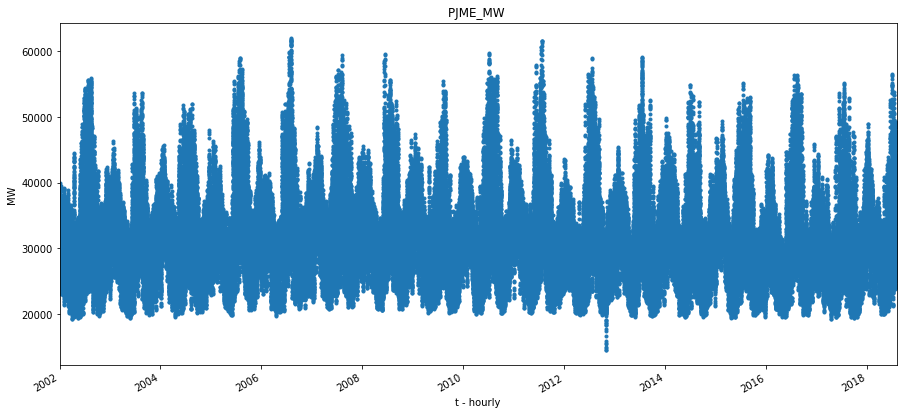

In [10]:
_ = df['PJME_MW'].plot( style='.', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t - hourly')
plt.show()

Это было почасовое потребление, посмотрим на ежедневное, недельное и месячное

In [11]:
df_d = df.resample('D').mean()

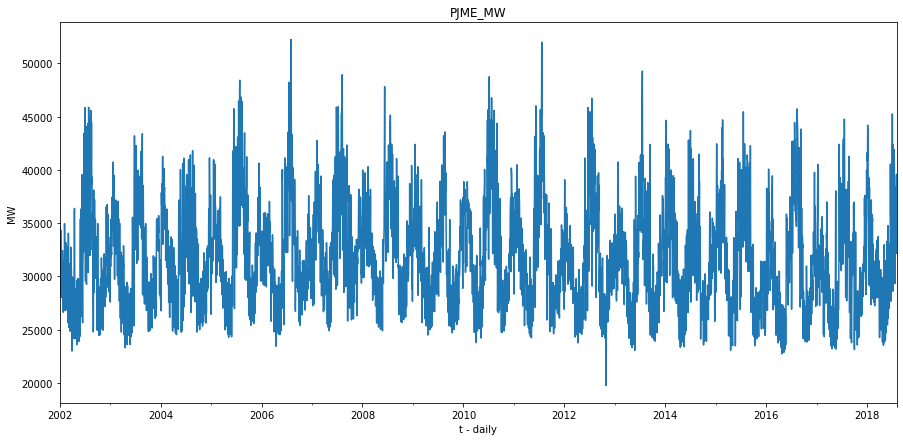

In [12]:
_ = df_d['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - daily')
plt.show()

In [13]:
df_w = df.resample('W').mean()

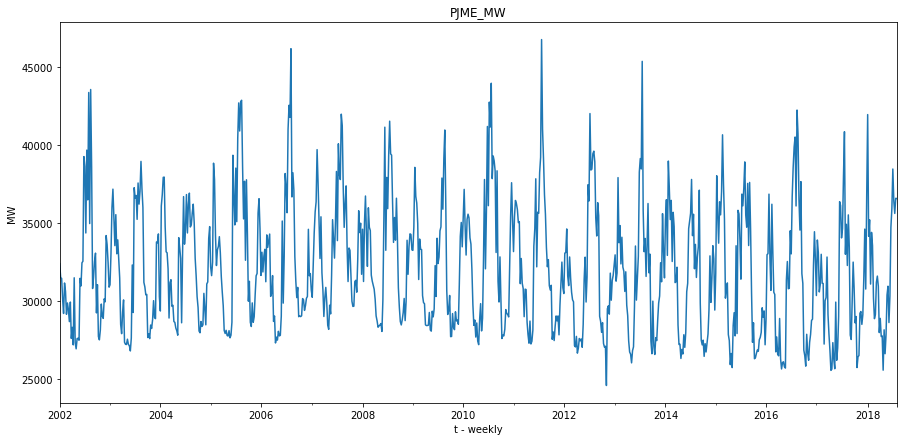

In [14]:
_ = df_w['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - weekly')
plt.show()

Мы видим цикличность потребления энергии. По виду данных, похоже на аддитивную сезонную модель. На месячном интервале она более сглаженная, посмотрим на годовую. 

## Проверим ряд на стационарность по тесту Дики-Фуллера(ADF) 

In [15]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Обращаемся к тесту с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды. Первый параметр должен содержать одномерный массив или Series

In [30]:
# Проверка ряда на стационарность по часовым частотам

In [16]:
DF_data_h = sm.tsa.stattools.adfuller(df['PJME_MW'].values,regression='ctt')
DF_data_h

(-20.07144387552255,
 0.0,
 75,
 145298,
 {'1%': -4.371209756407774,
  '5%': -3.8324306460238056,
  '10%': -3.553285187108092},
 2092088.4565295193)

In [23]:
print (f'Ключевой показатель теста = {DF_data_h[1]}')

Ключевой показатель теста = 0.0


Ключевой показатель теста = 0.0, ряд стационарен. 

In [ ]:
# Проверка ряда на стационарность по дневным частотам

In [17]:
DF_data_d = sm.tsa.stattools.adfuller(df_d['PJME_MW'].values,regression='ctt')
DF_data_d

(-8.365362138567198,
 4.282974615268831e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Ключевой показатель теста = 4.282974615268831e-11, ряд стационарен.

In [121]:
# Проверка ряда на стационарность по недельным частотам

In [18]:
DF_data_w = sm.tsa.stattools.adfuller(df_w['PJME_MW'].values,regression='ctt')
DF_data_w

(-13.618743234517353,
 3.1785518401463206e-22,
 11,
 854,
 {'1%': -4.384748970317034,
  '5%': -3.839322655125974,
  '10%': -3.5575526054344873},
 15405.229437796354)

Ключевой показатель теста = 3.1785518401463206e-22, то есть равен почти 0, ряд стационарен. 

## Сглаживание, выделение тренда.

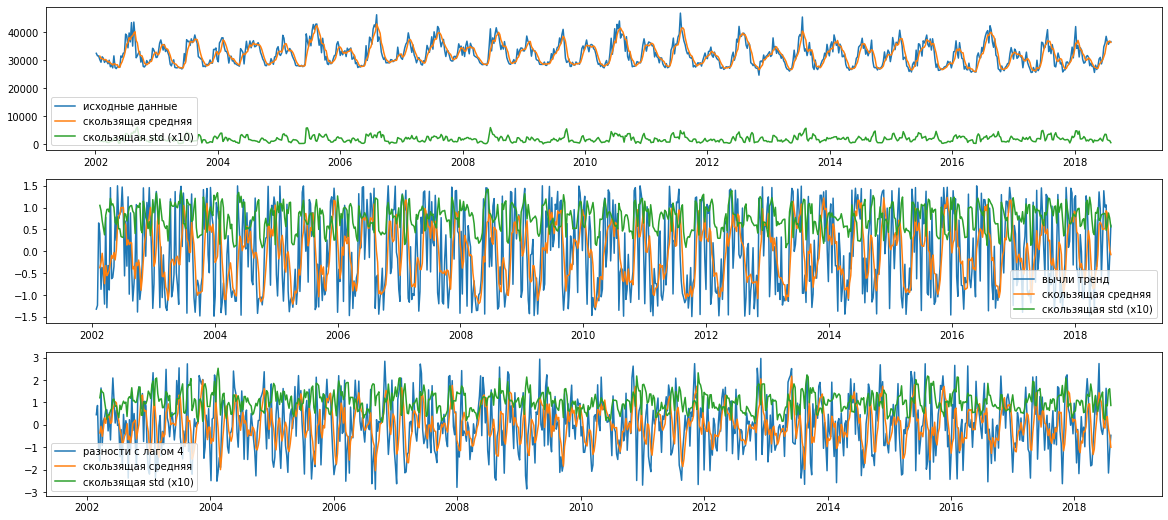

In [19]:
#сделаем окно на 4 неделb
N2 = 4

df_w['z_data'] = (df_w['PJME_MW'] - df_w['PJME_MW'].rolling(window=N2).mean()) / df_w['PJME_MW'].rolling(window=N2).std()
df_w['zp_data'] = df_w['z_data'] - df_w['z_data'].shift(N2)

def plot_rolling(df_w):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(df_w.index, df_w['PJME_MW'], label='исходные данные')
    ax[0].plot(df_w['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(df_w['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(df_w.index, df_w.z_data, label="вычли тренд")
    ax[1].plot(df_w.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(df_w.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(df_w.index, df_w.zp_data, label="разности с лагом " + str(N2))
    ax[2].plot(df_w.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(df_w.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(df_w) 

Попробуем учитывать предшествующее значение с коэффициентом памяти, например вот так (x(i)a + (1-a)(x(n-i+1)* a + (1-a)( ...+ (1-a)(x(i-n)))) - получим экспоненциальное сглаживание. 

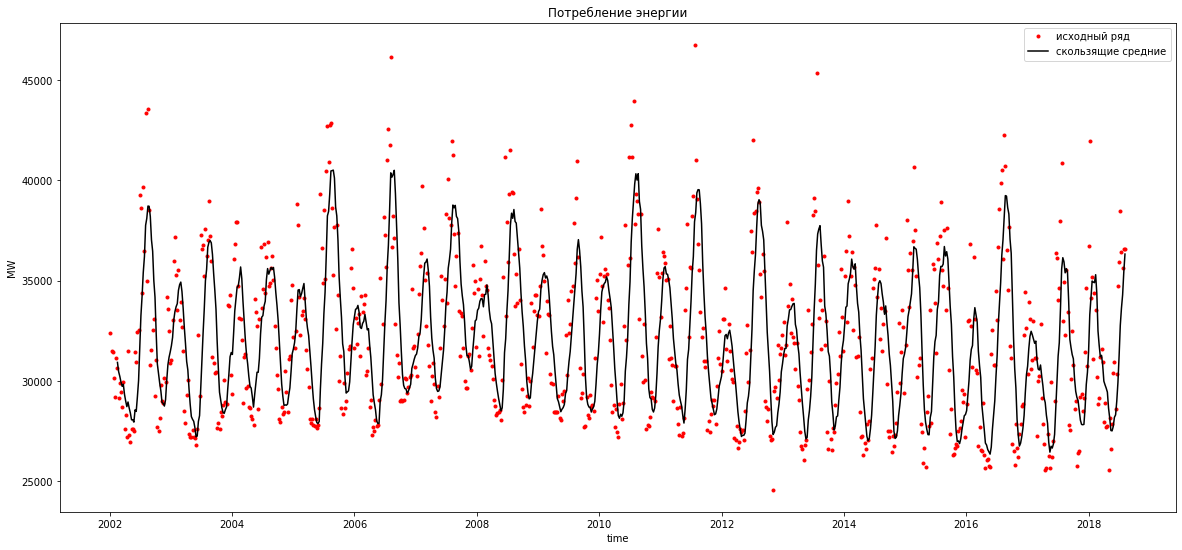

In [20]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# чем больше альфа, тем выше память у ряда, то есть повторяет историю
b_ar_exp_1 = exponential_smoothing(df_w['PJME_MW'], 0.07)

plt.figure(figsize=(20, 9))
plt.plot(df_w.index, df_w['PJME_MW'], '.r', label='исходный ряд')
plt.plot(df_w['PJME_MW'].rolling(window=7).mean(), label="скользящие средние", color = 'k');
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('Потребление энергии')
plt.show()

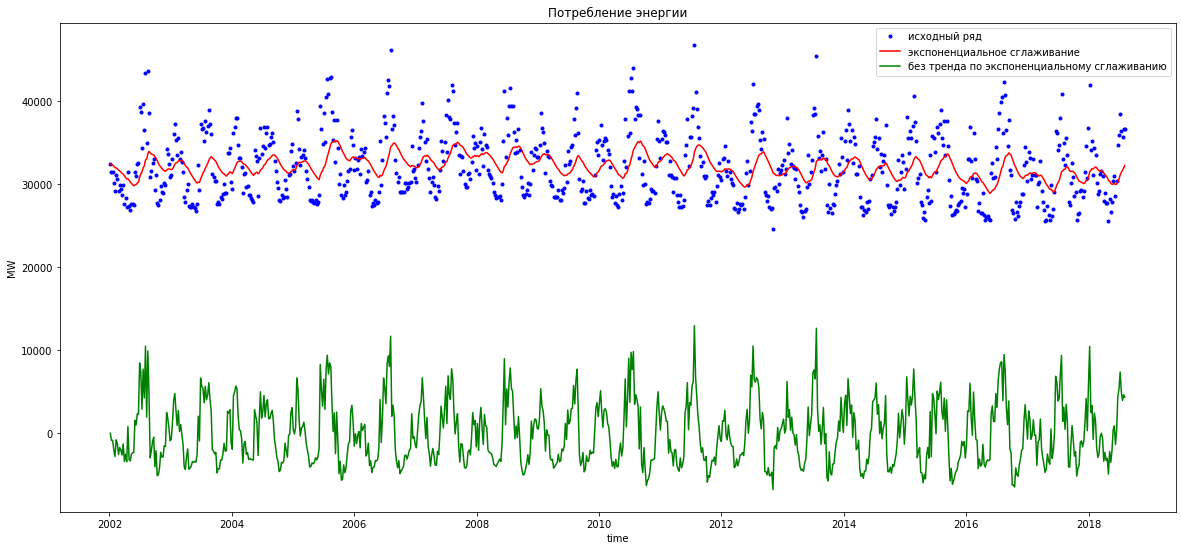

In [21]:
b_ar_exp_1 = exponential_smoothing(df_w['PJME_MW'], 0.06)

plt.figure(figsize=(20, 9))
plt.plot(df_w.index, df_w['PJME_MW'], '.b', label='исходный ряд')

plt.plot(df_w.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(df_w.index, df_w['PJME_MW'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('Потребление энергии')
plt.show()

Результаты сглаживания по экспоненциальной модели заметно ближе и больше похожи на основное направление изменения потребления энергии, чем обычное скользящее среднее. 

In [22]:
df_d.isnull().sum()

PJME_MW            0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
hour               0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

ряд нестационарен

## Добавление признаков

In [23]:
#Возьмем за основу для модели недельный ряд
df_m = pd.DataFrame({'value': df_w['PJME_MW']}, index=df_w.index)

In [24]:
 # добавили историю на глубину 3 измерения от текущего (р=3)
df_m['t'] = 0
df_m.iloc[1:,1]=df_m.iloc[:-1,0].values
df_m['t1']=0
df_m.iloc[2:,2]=df_m.iloc[:-2,0].values
df_m['t2']=0
df_m.iloc[3:,3]=df_m.iloc[:-3,0].values

In [25]:
# добавили сглаживание (3 вида - просто для коллекции)
df_m['exp_0_01'] = exponential_smoothing(df_m.value, 0.01)
df_m['exp_0_03'] = exponential_smoothing(df_m.value, 0.03)
df_m['exp_0_08'] = exponential_smoothing(df_m.value, 0.08)

In [26]:
# добавим разности - 1-й порядок
df_m['diff1'] = df_m['value'].diff()

In [27]:
df_m.head()

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,NaN
2002-01-13,31487.386905,32392.160839,0.000000,0.000000,32383.113100,32365.017621,32319.778924,-904.773934
2002-01-20,31452.880952,31487.386905,32392.160839,0.000000,32373.810778,32337.653521,32250.427087,-34.505952
2002-01-27,30141.529762,31452.880952,31487.386905,32392.160839,32351.487968,32271.769808,32081.715301,-1311.351190
2002-02-03,29196.488095,30141.529762,31452.880952,31487.386905,32319.937969,32179.511357,31850.897124,-945.041667


In [28]:
# добавим скользящее среднее с длиной сглаживания 1,  3 и 5 недель
df_m['ma_1'] = df_m.value.rolling(1).mean().values
df_m['ma_3'] = df_m.value.rolling(3).mean().values
df_m['ma_5'] = df_m.value.rolling(5).mean().values

In [29]:
df_m.isnull().sum()

value       0
t           0
t1          0
t2          0
exp_0_01    0
exp_0_03    0
exp_0_08    0
diff1       1
ma_1        0
ma_3        2
ma_5        4
dtype: int64

In [30]:
# добавим среднеквадратиечкое отклонение  с длиной сглаживания 1, 3 и 5 недель 
df_m['std_1'] = df_m.value.rolling(1).std().values
df_m['std_3'] = df_m.value.rolling(3).std().values
df_m['std_5'] = df_m.value.rolling(5).std().values

In [31]:
df_m.fillna(0, inplace=True)
df_m.head(4)

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1,ma_1,ma_3,ma_5,std_1,std_3,std_5
Date,,,,,,,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.000000,32392.160839,0.000000,0.0,0.0,0.000000,0.0
2002-01-13,31487.386905,32392.160839,0.000000,0.000000,32383.113100,32365.017621,32319.778924,-904.773934,31487.386905,0.000000,0.0,0.0,0.000000,0.0
2002-01-20,31452.880952,31487.386905,32392.160839,0.000000,32373.810778,32337.653521,32250.427087,-34.505952,31452.880952,31777.476232,0.0,0.0,532.611997,0.0
2002-01-27,30141.529762,31452.880952,31487.386905,32392.160839,32351.487968,32271.769808,32081.715301,-1311.351190,30141.529762,31027.265873,0.0,0.0,767.263976,0.0


## Разделим данные на тестовые и тренировочные во временных рядах

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data(df_m, '20-10-2016')

In [33]:
train.head()

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1,ma_1,ma_3,ma_5,std_1,std_3,std_5
Date,,,,,,,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.000000,32392.160839,0.000000,0.000000,0.0,0.000000,0.000000
2002-01-13,31487.386905,32392.160839,0.000000,0.000000,32383.113100,32365.017621,32319.778924,-904.773934,31487.386905,0.000000,0.000000,0.0,0.000000,0.000000
2002-01-20,31452.880952,31487.386905,32392.160839,0.000000,32373.810778,32337.653521,32250.427087,-34.505952,31452.880952,31777.476232,0.000000,0.0,532.611997,0.000000
2002-01-27,30141.529762,31452.880952,31487.386905,32392.160839,32351.487968,32271.769808,32081.715301,-1311.351190,30141.529762,31027.265873,0.000000,0.0,767.263976,0.000000
2002-02-03,29196.488095,30141.529762,31452.880952,31487.386905,32319.937969,32179.511357,31850.897124,-945.041667,29196.488095,30263.632937,30934.089311,0.0,1133.141240,1259.827786


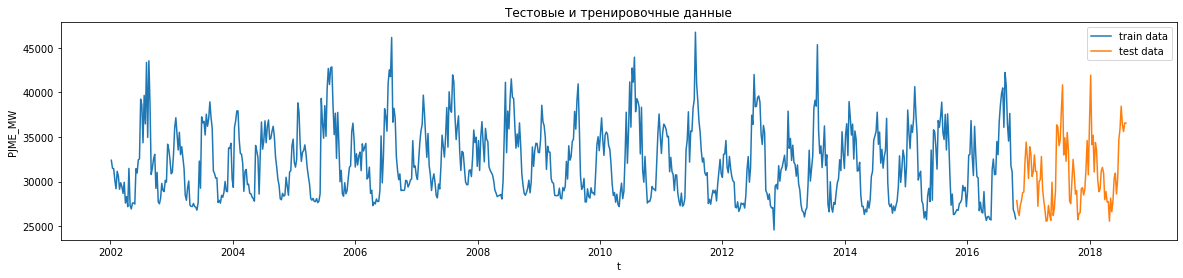

In [34]:
#поставим глубину прогноза 1
h = 1

X_train_1 = train.iloc[:-h, :]
y_train_1 = train['value'].values[h:]
X_test_1 = test.iloc[:-h, :]
y_test_1 = test['value'].values[h:]

plt.figure(figsize=(20, 4))
plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(train.index.get_level_values('Date'), train['value'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['value'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

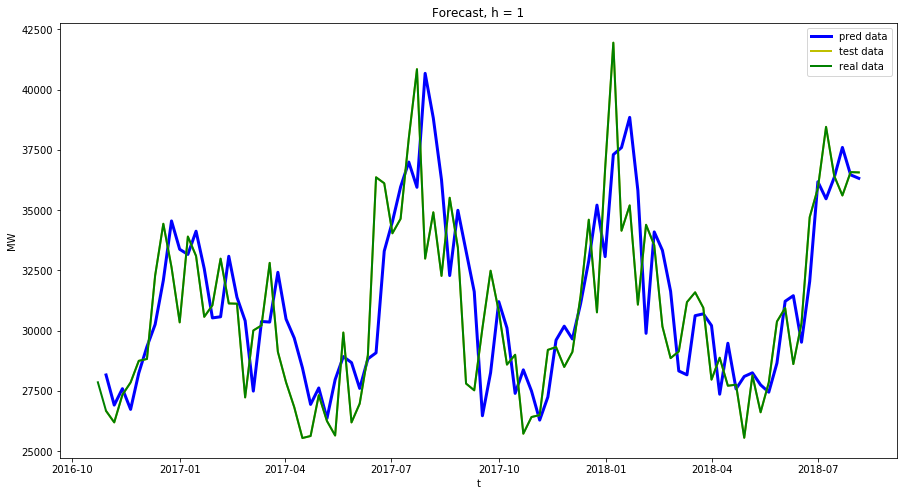

Mean absolute percantage error (h = 1): 6.3798%


In [36]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model.fit(X_train_1, y_train_1) 

y_test_pred_1 = model.predict(X_test_1)

plt.figure(figsize=(15, 8))

plt.title('Forecast, h = 1')

plt.xlabel('t')
plt.ylabel('MW')
plt.plot(test.index[h:], y_test_pred_1, label='pred data', linewidth=3.0, color = 'b')
plt.plot(test.index[h:], y_test_1, label='test data', linewidth=2.0, color = 'y' )
plt.plot(df_m.loc['2016-10-21':].index, df_m.loc['2016-10-21':]['value'], label='real data', linewidth=2.0, color = 'g')

plt.legend()
plt.show()

mape_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test_pred_1)

print(f'Mean absolute percantage error (h = 1): {np.round(mape_1, 4)}%')

## Построим прогноз на основе модели SARIMAX

In [37]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [38]:
import itertools

In [39]:
from tqdm.notebook import tqdm

In [40]:
import warnings

### Подберем параметры модели SARIMAX для этого ряда

Как глубоко будем смотреть в нашей модели?

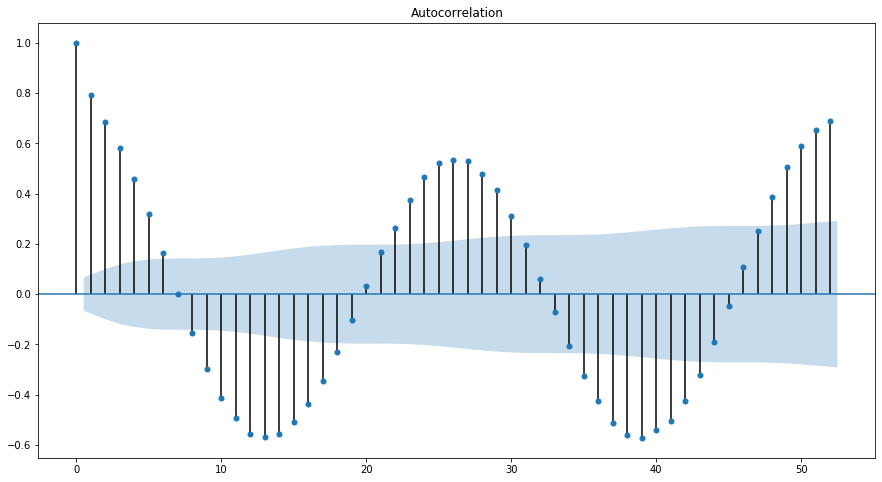

In [41]:
#посмотрим на к-т автокорреляции с лагом в 1 год - 52 недели 

sm.graphics.tsa.plot_acf(df_m['value'].values, lags=52)
plt.show()

Наблюдаем сезонность каждые 52 недели. Выбираем 52 недели в качестве параметра цикла сезонности для модели SARIMAX

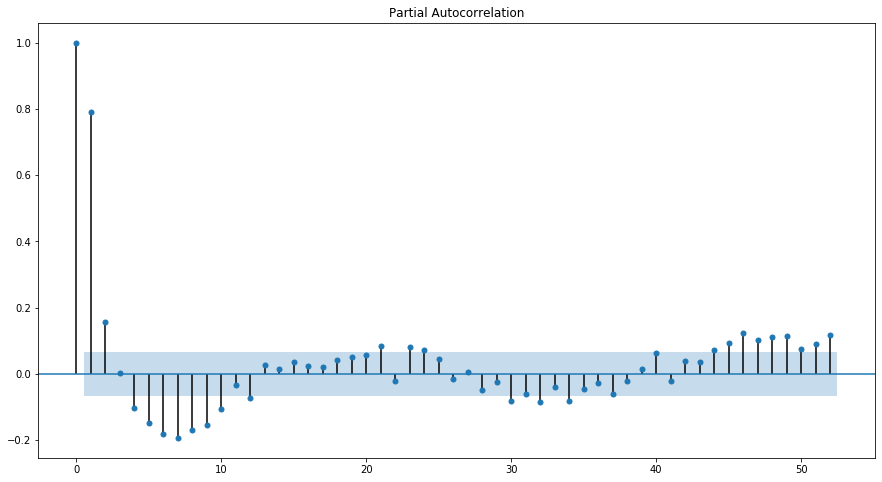

In [42]:
#Посмотрим на к-т частичное автокорреляции, чтобы оценить параметр дифференциации 

sm.graphics.tsa.plot_pacf(df_m['value'].values, lags=52)
plt.show()

d=1 достаточно будет добавить 1 уровень дифференцирования

In [43]:
p = d = q = range(3)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [44]:
test_period = 52 #количество недель для тестовой выборки 

In [45]:
warnings.filterwarnings("ignore")

results = dict()

for param in tqdm(pdq):
    
    for seasonal_param in seasonal_pdq:
        
        try:
            
            model = sm.tsa.statespace.SARIMAX(
                                        df_m['value'].values[:-test_period],
                                        order=param,
                                        seasonal_order=seasonal_param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )

            result = model.fit()
           
            results[(param, seasonal_param)] = result.aic
            
        except:
            
            continue
            
best_results = sorted(results.items(), key=lambda x: x[1])[0]

print(f'Best params: p, d, q = {best_results[0][0]}, ps, ds, qs, S = {best_results[0][1]}; best AIC: {best_results[1]}')


Best params: p, d, q = (0, 1, 2), ps, ds, qs, S = (2, 2, 2, 52); best AIC: 11115.59578675985


In [46]:
model = sm.tsa.statespace.SARIMAX(
                                df_m['value'].values[:-test_period],
                                order=best_results[0][0],
                                seasonal_order=best_results[0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )

result = model.fit()

In [47]:
print(result.summary().tables[0], result.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  814
Model:             SARIMAX(0, 1, 2)x(2, 2, 2, 52)   Log Likelihood               -5550.798
Date:                            Thu, 21 May 2020   AIC                          11115.596
Time:                                    02:33:14   BIC                          11146.398
Sample:                                         0   HQIC                         11127.585
                                            - 814                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

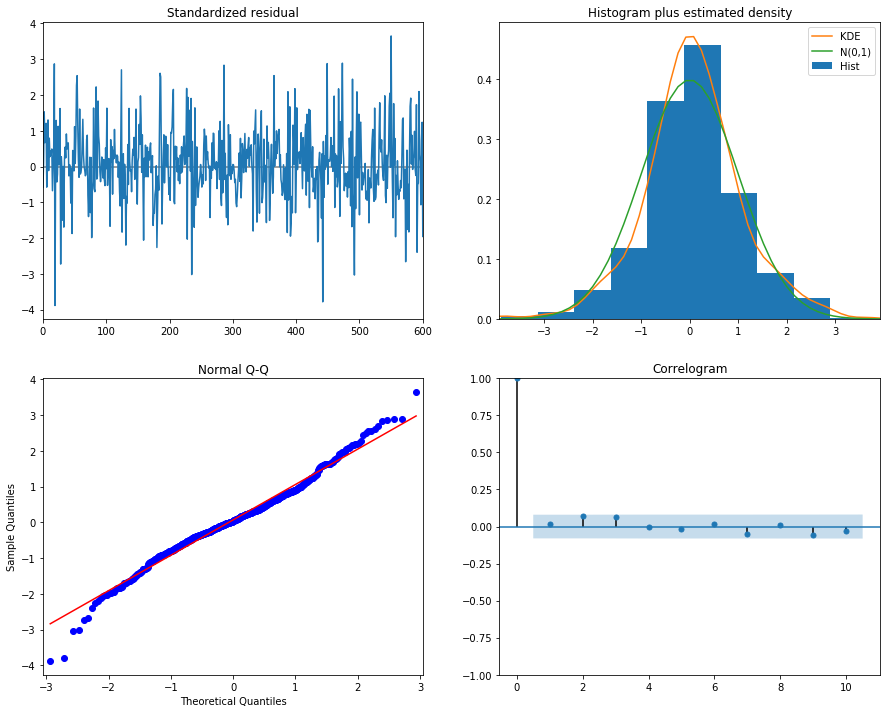

In [48]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

## Сравним модели на основе алгоритма GradientBoostingRegressor и SARIMAX

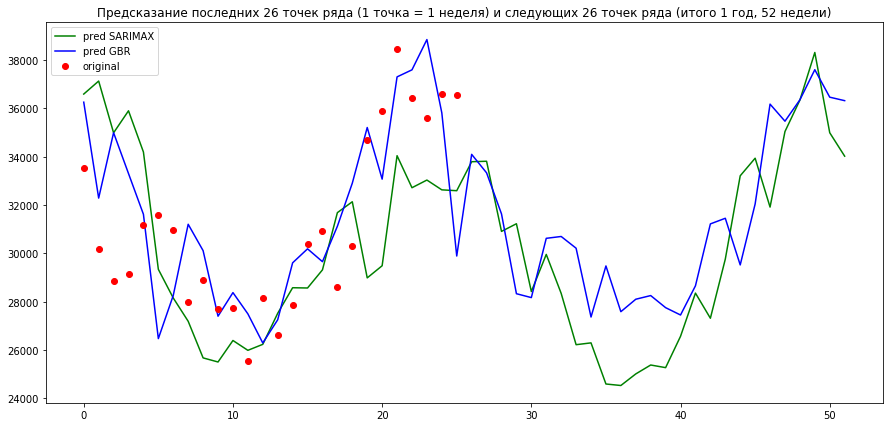

In [49]:
plt.figure(figsize=(15, 7))

sarimax_pred = result.forecast(52)

plt.plot(sarimax_pred, 'g', label='pred SARIMAX')
plt.plot(y_test_pred_1[41:], 'b', label='pred GBR') 
plt.plot(df_m['value'].values[-26:], 'or', label='original')

plt.title('Предсказание последних 26 точек ряда (1 точка = 1 неделя) и следующих 26 точек ряда (итого 1 год, 52 недели)')
plt.legend()

plt.show()

In [50]:
mape_xgb = mean_absolute_percentage_error(df_m['value'].values[-26:], y_pred=y_test_pred_1[41:67])
mape_SARIMAX = mean_absolute_percentage_error(df_m['value'].values[-26:], y_pred=sarimax_pred[:26])

In [51]:
print(f'Mean absolute percantage error XGB: {np.round(mape_xgb, 4)}%') 

Mean absolute percantage error XGB: 7.159%


In [52]:
print(f'Mean absolute percantage error SARIMAX: {np.round(mape_SARIMAX, 4)}%')  

Mean absolute percantage error SARIMAX: 9.8678%


## Выводы 

Модель SARIMAX показла ХУЖЕ результат, чем  GradientBoostingRegressor на периоде в 52 недели, но лучше на 26 недель

Остатки близки к нормальному распределению

Модель хорошо себя показала, потому что в данных не было сильных аномалий